In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,6)

import numpy as np
np.random.seed = 777

In [2]:
import h5py
f = h5py.File("hepjets/test_no_pile_5000000.h5", "r")
X_no_pile = f["features"].value
y_no_pile = f["targets"].value.ravel()

f = h5py.File("hepjets/test_pile_5000000.h5", "r")
X_pile = f["features"].value
y_pile = f["targets"].value.ravel()

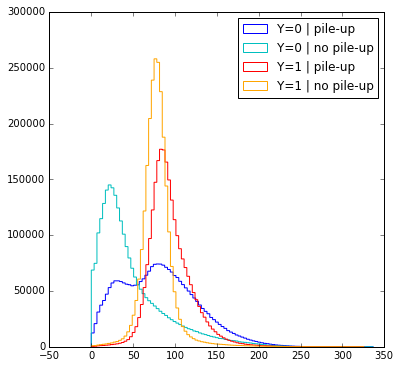

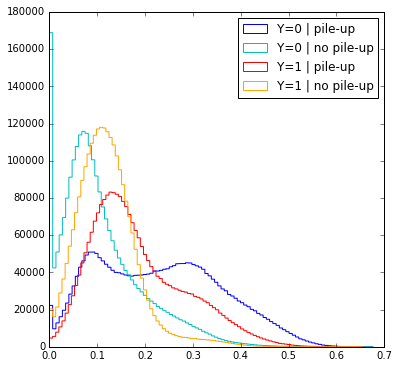

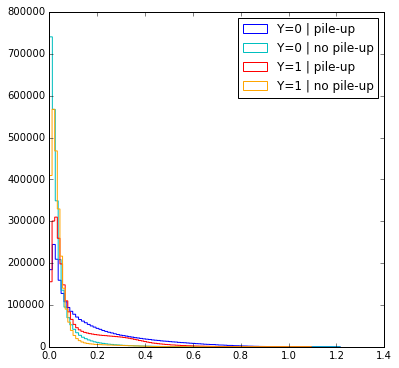

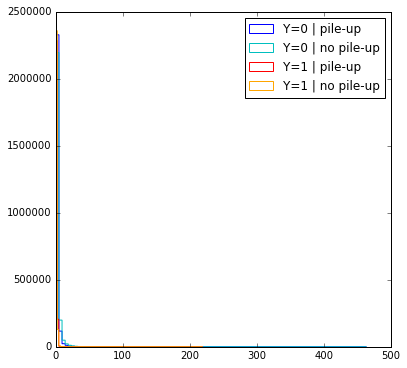

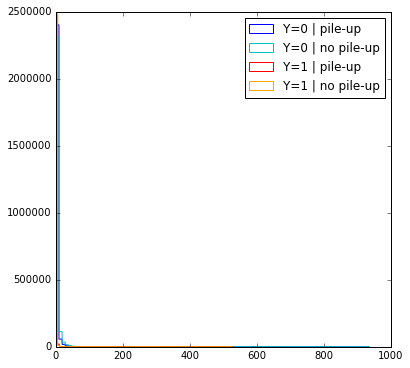

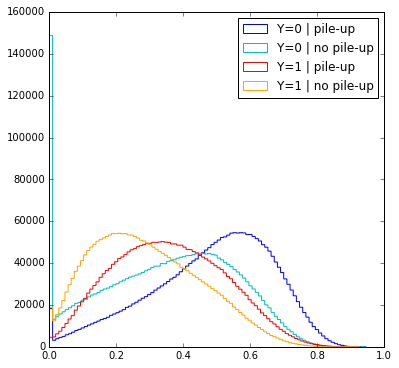

In [3]:
for i in range(X_pile.shape[1]):
    _, r, _ = plt.hist(X_pile[y_pile == 0, i], bins=100, color="b",  histtype="step",label="Y=0 | pile-up")
    plt.hist(X_no_pile[y_no_pile == 0, i], bins=r, color="c", histtype="step", label="Y=0 | no pile-up")
    _, r, _ = plt.hist(X_pile[y_pile == 1, i], bins=100, color="r",  histtype="step",label="Y=1 | pile-up")
    plt.hist(X_no_pile[y_no_pile == 1, i], bins=r, color="orange", histtype="step", label="Y=1 | no pile-up")
    plt.legend()
    #plt.savefig("hist-%s.png" % labels[1+i])
    plt.show()

In [4]:
from sklearn.cross_validation import train_test_split

X = np.vstack((X_no_pile, X_pile))
y = np.concatenate((y_no_pile, y_pile)).ravel()
z = np.zeros(len(X))
z[len(X_no_pile):] = 1

strates = np.zeros(len(X))
strates[(y==0)&(z==0)]=0
strates[(y==0)&(z==1)]=1
strates[(y==1)&(z==0)]=2
strates[(y==1)&(z==1)]=3

from keras.utils import np_utils
z = np_utils.to_categorical(z.astype(np.int))

from sklearn.preprocessing import StandardScaler
tf = StandardScaler()
X = tf.fit_transform(X)

X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X, y, z, test_size=25000, random_state=1, stratify=strates)

Using Theano backend.


In [5]:
X_train = X_train[:150000]
y_train = y_train[:150000]
z_train = z_train[:150000]

In [6]:
X_train.shape, X_test.shape, z_train.shape

((150000, 6), (25000, 6), (150000, 2))

In [7]:
import pickle
fd = open("jets-pile-150k.pickle", "wb")
pickle.dump((X_train, X_test, y_train, y_test, z_train, z_test), fd, protocol=2)
fd.close()

In [8]:
import keras.backend as K
from keras.layers import Input, Dense
from keras.models import Model

seed = 1
np.random.seed = seed

inputs = Input(shape=(X.shape[1],))
Dx = Dense(64, activation="tanh")(inputs)
Dx = Dense(64, activation="relu")(Dx)
Dx = Dense(64, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
D = Model(input=[inputs], output=[Dx])

Rx = D(inputs)
Rx = Dense(64, activation="relu")(Rx)
Rx = Dense(64, activation="relu")(Rx)
Rx = Dense(64, activation="relu")(Rx)
Rx = Dense(z.shape[1], activation="softmax")(Rx)
R = Model(input=[inputs], output=[Rx])

In [9]:
from keras.optimizers import SGD, Adam
import keras.backend as K

lam = 1.0

def make_loss_D(c):
    def loss_D(y_true, y_pred):
        return c * K.binary_crossentropy(y_pred, y_true)
    return loss_D

def make_loss_R(c):
    def loss_R(z_true, z_pred):
        return c * K.categorical_crossentropy(z_pred, z_true)
    return loss_R

opt_D = Adam()
D.compile(loss=[make_loss_D(c=1.0)], optimizer=opt_D)

opt_DRf = SGD(momentum=0) 
DRf = Model(input=[inputs], output=[D(inputs), R(inputs)])
DRf.compile(loss=[make_loss_D(c=1.0), 
                  make_loss_R(c=-lam)],   # compare with c=0.0, ie. when no there is no adversary
            optimizer=opt_DRf)

opt_DfR = SGD(momentum=0)
DfR = Model(input=[inputs], output=[R(inputs)])
DfR.compile(loss=[make_loss_R(c=1.0)], 
            optimizer=opt_DfR)

In [10]:
DRf.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 6)             0                                            
____________________________________________________________________________________________________
model_1 (Model)                  (None, 1)             8833        input_1[0][0]                    
____________________________________________________________________________________________________
model_2 (Model)                  (None, 2)             17411       input_1[0][0]                    
Total params: 26244
____________________________________________________________________________________________________


In [11]:
DfR.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 6)             0                                            
____________________________________________________________________________________________________
model_2 (Model)                  (None, 2)             17411       input_1[0][0]                    
Total params: 17411
____________________________________________________________________________________________________


In [135]:
# Pretraining of D
D.trainable = True
R.trainable = False
D.fit(X_train, y_train, nb_epoch=5)

Epoch 1/5
75000/75000 [==============================] - 1s - loss: 0.3527     
Epoch 2/5
75000/75000 [==============================] - 1s - loss: 0.3358     
Epoch 3/5
75000/75000 [==============================] - 1s - loss: 0.3333     
Epoch 4/5
75000/75000 [==============================] - 1s - loss: 0.3317     
Epoch 5/5
75000/75000 [==============================] - 1s - loss: 0.3308     


In [136]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, D.predict(X_test)), roc_auc_score(y_test[z_test[:, 0]==1], D.predict(X_test[z_test[:, 0]==1])), roc_auc_score(y_test[z_test[:, 1]==1], D.predict(X_test[z_test[:, 1]==1]))

(0.93425612479999987, 0.9409091584, 0.92758498560000002)

In [137]:
y_pred_union = D.predict(X_test)

In [14]:
X_test_z0 = X_test[z_test[:, 0] == 1]
y_test_z0 = y_test[z_test[:, 0] == 1]
X_test_z1 = X_test[z_test[:, 1] == 1]
y_test_z1 = y_test[z_test[:, 1] == 1]

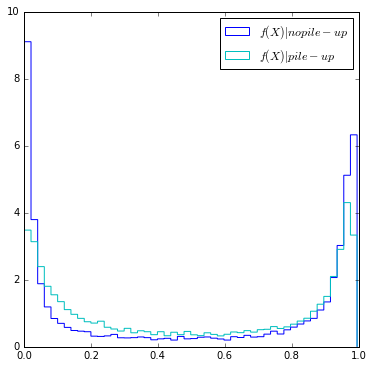

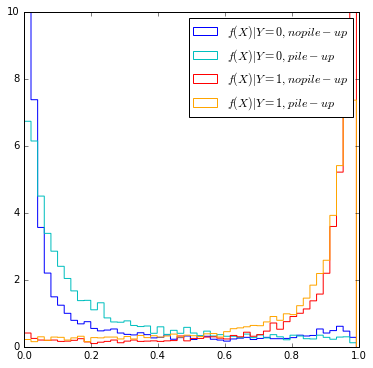

In [138]:
_, r, _ = plt.hist(D.predict(X_test_z0), 
         bins=50, color="b", normed=1, histtype="step", label="$f(X)|no pile-up$")
plt.hist(D.predict(X_test_z1), 
         bins=r, color="c", normed=1, histtype="step", label="$f(X)|pile-up$")
plt.legend(loc="best")
plt.ylim(0, 10.)
plt.show()

_, r, _ = plt.hist(D.predict(X_test_z0[y_test_z0 == 0]), 
         bins=50, color="b", normed=1, histtype="step", label="$f(X)|Y=0, no pile-up$")
plt.hist(D.predict(X_test_z1[y_test_z1 == 0]), 
         bins=r, color="c", normed=1, histtype="step", label="$f(X)|Y=0, pile-up$")
plt.hist(D.predict(X_test_z0[y_test_z0 == 1]), 
         bins=r, color="r", normed=1, histtype="step", label="$f(X)|Y=1, no pile-up$")
plt.hist(D.predict(X_test_z1[y_test_z1 == 1]),  
         bins=r, color="orange", normed=1, histtype="step", label="$f(X)|Y=1, pile-up$")
plt.legend(loc="best")
plt.ylim(0, 10.)
plt.show()

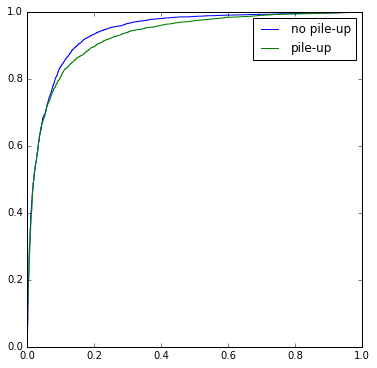

In [139]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test_z0, D.predict(X_test_z0))
plt.plot(fpr, tpr, label="no pile-up")
fpr, tpr, _ = roc_curve(y_test_z1, D.predict(X_test_z1))
plt.plot(fpr, tpr, label="pile-up")
plt.legend()
plt.show()

In [140]:
# Pretraining of R
D.trainable = False
R.trainable = True
DfR.fit(X_train[y_train==0], z_train[y_train==0], nb_epoch=20)

Epoch 1/20
37168/37168 [==============================] - 1s - loss: 0.6890     
Epoch 2/20
37168/37168 [==============================] - 0s - loss: 0.6868     
Epoch 3/20
37168/37168 [==============================] - 0s - loss: 0.6849     
Epoch 4/20
37168/37168 [==============================] - 1s - loss: 0.6825     
Epoch 5/20
37168/37168 [==============================] - 0s - loss: 0.6794     
Epoch 6/20
37168/37168 [==============================] - 0s - loss: 0.6756     
Epoch 7/20
37168/37168 [==============================] - 1s - loss: 0.6711     
Epoch 8/20
37168/37168 [==============================] - 0s - loss: 0.6660     
Epoch 9/20
37168/37168 [==============================] - 0s - loss: 0.6617     
Epoch 10/20
37168/37168 [==============================] - 0s - loss: 0.6584     
Epoch 11/20
37168/37168 [==============================] - 0s - loss: 0.6563     
Epoch 12/20
37168/37168 [==============================] - 0s - loss: 0.6545     
Epoch 13/20
37168/37168 [

In [141]:
from IPython import display

from scipy.stats import entropy
min_Lr = entropy([1. / 2] * 2)

def plot_losses(i, losses):
    display.clear_output(wait=True)
    display.display(plt.gcf())

    ax1 = plt.subplot(311)   
    #plt.axhline(y=min_Lf, ls="dashed")
    values = np.array(losses["L_f"])
    plt.plot(range(len(values)), values, label=r"$L_f$", color="blue")
    plt.legend(loc="upper right")
    
    ax2 = plt.subplot(312, sharex=ax1) 
    plt.axhline(y=min_Lr, ls="dashed")
    values = np.array(losses["L_r"]) / lam
    plt.plot(range(len(values)), values, label=r"$L_r$", color="green")
    plt.legend(loc="lower right")
    
    ax3 = plt.subplot(313, sharex=ax1)
    #plt.axhline(y=min_Lf - lam*min_Lr, ls="dashed")
    values = np.array(losses["L_f - L_r"])
    plt.plot(range(len(values)), values, label=r"$L_f - \lambda L_r$", color="red")  
    plt.legend(loc="upper right")
    
    plt.show()   

In [142]:
losses = {"L_f": [], "L_r": [], "L_f - L_r": []}

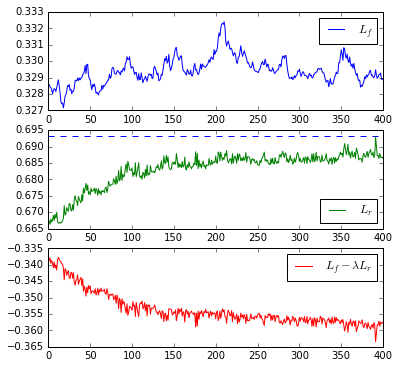

Epoch 1/1
37168/37168 [==============================] - 0s - loss: 0.6848     
Epoch 1/1
37168/37168 [==============================] - 0s - loss: 0.6852     
Epoch 1/1
37168/37168 [==============================] - 0s - loss: 0.6849     
Epoch 1/1
37168/37168 [==============================] - 0s - loss: 0.6848     
Epoch 1/1
 3072/37168 [=>............................] - ETA: 0s - loss: 0.6854

KeyboardInterrupt: 

In [145]:
batch_size = 128

for i in range(1001):
    l = DRf.evaluate(X_test, [y_test, z_test], verbose=0)    
    losses["L_f - L_r"].append(l[0][None][0])
    losses["L_f"].append(l[1][None][0])
    losses["L_r"].append(-l[2][None][0])
    
    if i % 5 == 0:
        plot_losses(i, losses)
    
    # Fit D
    D.trainable = True
    R.trainable = False
    indices = np.random.permutation(len(X_train))[:batch_size]
    DRf.train_on_batch(X_train[indices], [y_train[indices], z_train[indices]])
    
    # Fit R
    D.trainable = False
    R.trainable = True

    DfR.fit(X_train[y_train==0], z_train[y_train==0], batch_size=batch_size, nb_epoch=1, verbose=1)
#     for j in range(100):
#         indices = np.random.permutation(len(X_train))[:2*batch_size]
#         mask = (y_train[indices] == 0)
#         DfR.train_on_batch(X_train[indices][mask], z_train[indices][mask])

In [16]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, D.predict(X_test)), roc_auc_score(y_test[z_test[:, 0]==1], D.predict(X_test[z_test[:, 0]==1])), roc_auc_score(y_test[z_test[:, 1]==1], D.predict(X_test[z_test[:, 1]==1]))

(0.92758887999999995, 0.94404770560000006, 0.90775660800000013)

In [15]:
D.load_weights("D-0.0000-1-z=0.h5")

In [12]:
y_pred_adv = D.predict(X_test)

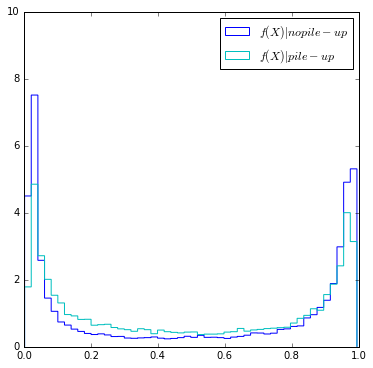

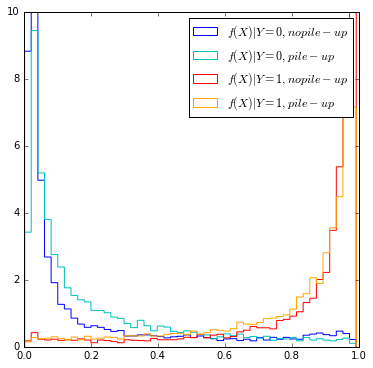

In [15]:
_, r, _ = plt.hist(D.predict(X_test_z0), 
         bins=50, color="b", normed=1, histtype="step", label="$f(X)|no pile-up$")
plt.hist(D.predict(X_test_z1), 
         bins=r, color="c", normed=1, histtype="step", label="$f(X)|pile-up$")
plt.legend(loc="best")
plt.ylim(0, 10.)
plt.show()

_, r, _ = plt.hist(D.predict(X_test_z0[y_test_z0 == 0]), 
         bins=50, color="b", normed=1, histtype="step", label="$f(X)|Y=0, no pile-up$")
plt.hist(D.predict(X_test_z1[y_test_z1 == 0]), 
         bins=r, color="c", normed=1, histtype="step", label="$f(X)|Y=0, pile-up$")
plt.hist(D.predict(X_test_z0[y_test_z0 == 1]), 
         bins=r, color="r", normed=1, histtype="step", label="$f(X)|Y=1, no pile-up$")
plt.hist(D.predict(X_test_z1[y_test_z1 == 1]),  
         bins=r, color="orange", normed=1, histtype="step", label="$f(X)|Y=1, pile-up$")
plt.legend(loc="best")
plt.ylim(0, 10.)
plt.show()

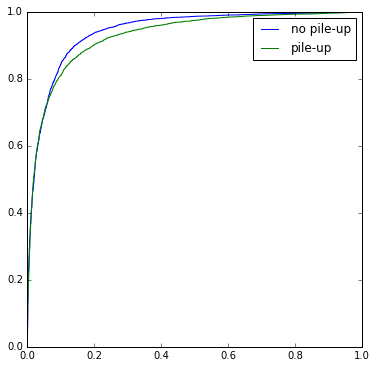

In [16]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test_z0, D.predict(X_test_z0))
plt.plot(fpr, tpr, label="no pile-up")
fpr, tpr, _ = roc_curve(y_test_z1, D.predict(X_test_z1))
plt.plot(fpr, tpr, label="pile-up")
plt.legend()
plt.show()

In [12]:
def plot_AMS1(pred,Y,Z, label):
    x00 = np.sort(pred[((Y==0)*(Z==0))].flatten())
    x01 = np.sort(pred[((Y==0)*(Z==1))].flatten())
    x10 = np.sort(pred[((Y==1)*(Z==0))].flatten())
    #x10 = np.sort(pred[(Y==1)].flatten())
    #x11 = np.sort(pred[((Y==1)*(Z==1))].flatten())
 
    n_points = 100
    AMS1 = np.zeros(n_points)
    all_ns = np.zeros(n_points)
    all_nb = np.zeros(n_points)
    all_nb1 = np.zeros(n_points)
    all_sigb = np.zeros(n_points)

    cuts = np.zeros(n_points)
    sig_eff = np.zeros(n_points)
    ns_tot = x10.shape[0]
    
    for i, c_i in enumerate(np.linspace(0.0, 1.0, n_points)):
        cuts[i] = c_i
        
        ns = (100 / x10.size) * np.count_nonzero(x10 > c_i) 
        nb = (1000 / x00.size) * np.count_nonzero(x00 > c_i) 
        nb1 = (1000 / x01.size) * np.count_nonzero(x01 > c_i) 
        sig_b = 1.0 * np.abs(nb - nb1) 
        
        b0 = 0.5 * (nb - sig_b ** 2 + ((nb - sig_b ** 2) ** 2 + 4 * (ns + nb) * (sig_b ** 2)) ** 0.5)
        AMS1[i] = (2.0 * ((ns + nb) * np.log((ns + nb) / b0) - ns - nb + b0) + ((nb - b0) / sig_b) ** 2) ** 0.5
        
        all_ns[i] = ns
        all_nb[i] = nb
        all_nb1[i] = nb
        all_sigb[i] = sig_b
        
        sig_eff[i] = (1.0*ns) / ns_tot
        
    return cuts, AMS1
        
    #plt.plot(cuts, AMS1, '-', label=label)
    

D-0.0000-1-z=0.h5
D-0.0000-3-z=0.h5
D-0.0000-4-z=0.h5
D-0.0000-2-z=0.h5
D-0.0000-5-z=0.h5
y=0/D-0.0000-1.h5
y=0/D-0.0000-2.h5
y=0/D-0.0000-7.h5
y=0/D-0.0000-8.h5
y=0/D-0.0000-9.h5
y=0/D-0.0000-10.h5
y=0/D-0.0000-3.h5
y=0/D-0.0000-4.h5
y=0/D-0.0000-6.h5
y=0/D-0.0000-5.h5
y=0/D-1.0000-9.h5
y=0/D-1.0000-7.h5
y=0/D-1.0000-1.h5
y=0/D-1.0000-5.h5
y=0/D-1.0000-3.h5
y=0/D-1.0000-6.h5
y=0/D-1.0000-8.h5
y=0/D-1.0000-2.h5
y=0/D-1.0000-4.h5
y=0/D-1.0000-10.h5
y=0/D-10.0000-10.h5
y=0/D-10.0000-6.h5
y=0/D-10.0000-8.h5
y=0/D-10.0000-9.h5
y=0/D-10.0000-7.h5
y=0/D-500.0000-1.h5
y=0/D-500.0000-8.h5
y=0/D-500.0000-3.h5
y=0/D-500.0000-2.h5
y=0/D-500.0000-7.h5
y=0/D-500.0000-6.h5


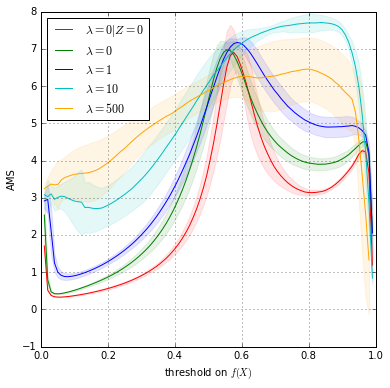

In [17]:
import glob

indices = np.random.permutation(len(X))
indices = indices[:5000000]

for lam, c in zip([0.0], ["r"]):
    ams = []

    for f in glob.glob("D-%.4f-*.h5" % lam):
        print(f)
        D.load_weights(f)
        cuts, a = plot_AMS1(D.predict(X[indices]), y[indices], z[indices, 1], f)
        ams.append(a)
        
    mu = np.mean(ams, axis=0) 
    std = np.std(ams, axis=0)
    plt.plot(cuts, mu, label=r"$\lambda=%d|Z=0$" % lam, c=c)
    plt.fill_between(cuts, mu+std, mu-std, color=c, alpha=0.1)
    
for lam, c in zip([0.0, 1.0, 10, 500.], ["g", "b", "c", "orange", "y", "grey", "k"]):
    ams = []

    for f in glob.glob("y=0/D-%.4f-*.h5" % lam):
        print(f)
        D.load_weights(f)
        cuts, a = plot_AMS1(D.predict(X[indices]), y[indices], z[indices, 1], f)
        ams.append(a)

#     mu = np.max(ams, axis=0) 
#     plt.plot(cuts, mu, label=r"$\lambda=%.2f$" % lam, c=c)
        
    mu = np.mean(ams, axis=0) 
    std = np.std(ams, axis=0)
    plt.plot(cuts, mu, label=r"$\lambda=%d$" % lam, c=c)
    plt.fill_between(cuts, mu+std, mu-std, color=c, alpha=0.1)
    
plt.legend(loc="best")
plt.ylabel("AMS")
plt.xlabel("threshold on $f(X)$")
plt.grid()
plt.savefig("ams.pdf")
plt.show()